In [ ]:
import random
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage
import sklearn
from sklearn.model_selection import train_test_split
import sktime
from sktime.datatypes._panel._convert import from_3d_numpy_to_nested
from sklearn.metrics import classification_report

In [ ]:
def median(raw, box_size, mode='nearest'): # Median Filter
    raw_median=ndimage.median_filter(raw,box_size,mode=mode)
    return raw_median.real

def maximum(raw, box_size, mode='nearest'): # Maximum Filter
    raw_maximum=ndimage.maximum_filter(raw,box_size,mode=mode)
    return raw_maximum.real

def minimum(raw, box_size, mode='nearest'): # Maximum Filter
    raw_minimum=ndimage.minimum_filter(raw,box_size,mode=mode)
    return raw_minimum.real

def denoise_fft(data, ifftn): # Fast Fourier Transformation
    fft_signal = np.fft.fft(data)
    
    # Reconstruct the original signal
    fft_signal[ifftn:len(fft_signal)//2]=0
    fft_signal[len(fft_signal)//2:-ifftn]=0
    reconstructed_signal = np.fft.ifft(fft_signal)
    
    return reconstructed_signal.real

def smooth(x,beta): # Kaiser Window Smoothing
    window_len=11  # extending the data at beginning and at the end to apply the window at the borders

    s = np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    w = np.kaiser(window_len,beta)
    y = np.convolve(w/w.sum(),s,mode='valid')
    return y[5:len(y)-5]


def denoise_signal(data, wavelet='db4', level=2):
    # 웨이블릿 변환 (모드를 'symmetric'으로 설정)
    coeff = pywt.wavedec(data, wavelet, mode='symmetric')
    # 노이즈 추정을 위한 임계값 계산
    sigma = np.median(np.abs(coeff[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(data)))
    # 임계값 적용 (soft thresholding)
    coeff = [pywt.threshold(c, value=uthresh, mode='soft') for c in coeff]
    # 역 웨이블릿 변환
    return pywt.waverec(coeff, wavelet, mode='symmetric')

<Figure size 640x480 with 0 Axes>

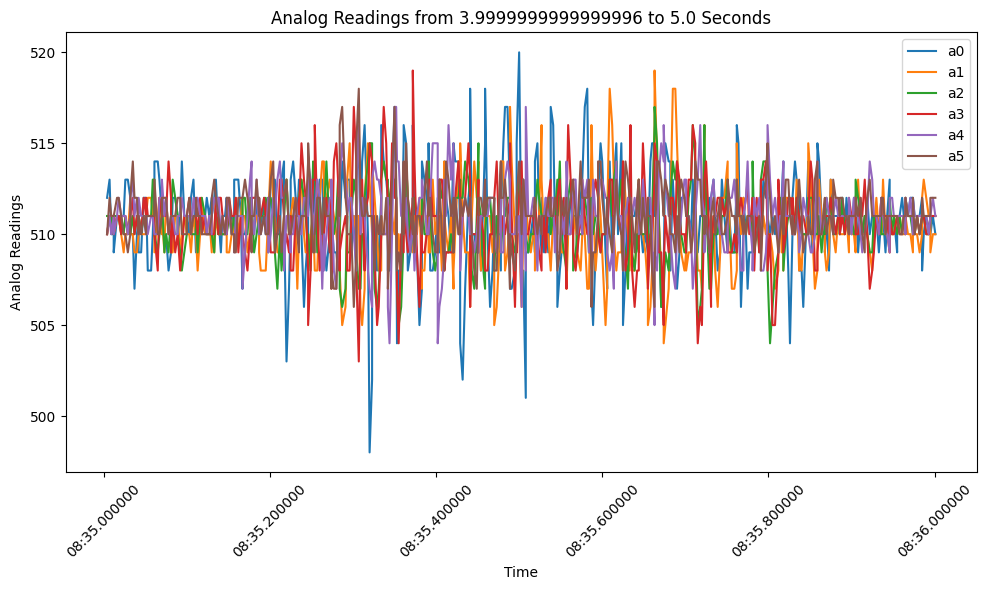

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# 데이터 프레임으로 읽기
df = pd.read_csv(f'data/scissors/scissors01.csv', header=None, names=['time', 'a0', 'a1', 'a2', 'a3', 'a4', 'a5'])

# 'time' 열을 datetime 형식으로 변환
df['time'] = pd.to_datetime(df['time'])

seconds_s = 0
seconds_e = 1

while(True):

    # 처음 4초부터 5초까지의 데이터 필터링
    start_time = df['time'].iloc[0] + pd.Timedelta(seconds=seconds_s)
    end_time = df['time'].iloc[0] + pd.Timedelta(seconds=seconds_e)
    df_filtered = df[(df['time'] >= start_time) & (df['time'] <= end_time)]

    # 데이터 그래프로 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(df_filtered['time'], df_filtered['a0'], label='a0')
    plt.plot(df_filtered['time'], df_filtered['a1'], label='a1')
    plt.plot(df_filtered['time'], df_filtered['a2'], label='a2')
    plt.plot(df_filtered['time'], df_filtered['a3'], label='a3')
    plt.plot(df_filtered['time'], df_filtered['a4'], label='a4')
    plt.plot(df_filtered['time'], df_filtered['a5'], label='a5')

    plt.xlabel('Time')
    plt.ylabel('Analog Readings')
    plt.title(f'Analog Readings from {seconds_s} to {seconds_e} Seconds')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    # 그래프 출력
    plt.show()

    inputc = input()

    if inputc == 'exit':
        break
    elif inputc == '':
        seconds_s += 0.1
        seconds_e += 0.1
    elif inputc == 'k':
        seconds_s -= 0.1
        seconds_e -= 0.1
    elif inputc == 'l':
        seconds_s += 4
        seconds_e += 4
    elif inputc == 's':
        file_path = 'data/new_scissors/filtered_data.csv'
        df_filtered.to_csv(file_path, index=False)
    clear_output(wait=True)
    display(plt.gcf())
    plt.close()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 프레임으로 읽기
df = pd.read_csv(f'data/scissors/scissors01.csv', header=None, names=['time', 'a0', 'a1', 'a2', 'a3', 'a4', 'a5'])



# 'time' 열을 datetime 형식으로 변환
df['time'] = pd.to_datetime(df['time'])

# 처음 4초부터 5초까지의 데이터 필터링
start_time = df['time'].iloc[0] + pd.Timedelta(seconds=9)
end_time = df['time'].iloc[0] + pd.Timedelta(seconds=10)
df_filtered = df[(df['time'] >= start_time) & (df['time'] <= end_time)]

# 데이터 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.plot(df_filtered['time'], df_filtered['a0'], label='a0')
plt.plot(df_filtered['time'], df_filtered['a1'], label='a1')
plt.plot(df_filtered['time'], df_filtered['a2'], label='a2')
plt.plot(df_filtered['time'], df_filtered['a3'], label='a3')
plt.plot(df_filtered['time'], df_filtered['a4'], label='a4')
plt.plot(df_filtered['time'], df_filtered['a5'], label='a5')

plt.xlabel('Time')
plt.ylabel('Analog Readings')
plt.title('Analog Readings from 4 to 5 Seconds')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# 그래프 출력
plt.show()



# 데이터 그래프로 시각화
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111)

# 필터링된 데이터에 대해 각 채널의 처리를 수행
for i in range(6):
    column = f'a{i}'  # 필터링된 데이터의 각 채널 컬럼명
    depths = smooth(denoise_fft(maximum(df_filtered[column], 20), 3), 5) - smooth(denoise_fft(minimum(df_filtered[column], 20), 3), 5)
    ax.plot(df_filtered['time'], depths, lw=1, label=f'ch{i+1}')

ax.legend()
plt.xlabel('Time')
plt.ylabel('Processed Readings')
plt.title('Processed Analog Readings from 4 to 5 Seconds')
plt.xticks(rotation=45)
plt.tight_layout()

# 그래프 출력
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 프레임으로 읽기
df = pd.read_csv(f'data/scissors/scissors10.csv', header=None, names=['time', 'a0', 'a1', 'a2', 'a3', 'a4', 'a5'])

# 'time' 열을 datetime 형식으로 변환
df['time'] = pd.to_datetime(df['time'])

# 처음 4초부터 5초까지의 데이터 필터링
start_time = df['time'].iloc[0] + pd.Timedelta(seconds=10)
end_time = df['time'].iloc[0] + pd.Timedelta(seconds=23)
df_filtered = df[(df['time'] >= start_time) & (df['time'] <= end_time)]

# 데이터 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.plot(df_filtered['time'], df_filtered['a0'], label='a0')
plt.plot(df_filtered['time'], df_filtered['a1'], label='a1')
plt.plot(df_filtered['time'], df_filtered['a2'], label='a2')
plt.plot(df_filtered['time'], df_filtered['a3'], label='a3')
plt.plot(df_filtered['time'], df_filtered['a4'], label='a4')
plt.plot(df_filtered['time'], df_filtered['a5'], label='a5')

plt.xlabel('Time')
plt.ylabel('Analog Readings')
plt.title('Analog Readings from 4 to 5 Seconds')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# 그래프 출력
plt.show()



# 데이터 그래프로 시각화
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111)

# 필터링된 데이터에 대해 각 채널의 처리를 수행
for i in range(6):
    column = f'a{i}'  # 필터링된 데이터의 각 채널 컬럼명
    depths = smooth(denoise_fft(maximum(df_filtered[column], 20), 10), 5) - smooth(denoise_fft(minimum(df_filtered[column], 20), 10), 5)
    ax.plot(df_filtered['time'], depths, lw=1, label=f'ch{i+1}')

ax.legend()
plt.xlabel('Time')
plt.ylabel('Processed Readings')
plt.title('Processed Analog Readings from 4 to 5 Seconds')
plt.xticks(rotation=45)
plt.tight_layout()

# 그래프 출력
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 프레임으로 읽기
df = pd.read_csv(f'data/scissors0.csv', header=None, names=['time', 'a0', 'a1', 'a2', 'a3', 'a4', 'a5'])

# 'time' 열을 datetime 형식으로 변환
df['time'] = pd.to_datetime(df['time'])

# 처음 4초부터 5초까지의 데이터 필터링
start_time = df['time'].iloc[0] + pd.Timedelta(seconds=20)
end_time = df['time'].iloc[0] + pd.Timedelta(seconds=43)
df_filtered = df[(df['time'] >= start_time) & (df['time'] <= end_time)]

# 데이터 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.plot(df_filtered['time'], df_filtered['a0'], label='a0')
plt.plot(df_filtered['time'], df_filtered['a1'], label='a1')
plt.plot(df_filtered['time'], df_filtered['a2'], label='a2')
plt.plot(df_filtered['time'], df_filtered['a3'], label='a3')
plt.plot(df_filtered['time'], df_filtered['a4'], label='a4')
plt.plot(df_filtered['time'], df_filtered['a5'], label='a5')

plt.xlabel('Time')
plt.ylabel('Analog Readings')
plt.title('Analog Readings from 4 to 5 Seconds')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# 그래프 출력
plt.show()



# 데이터 그래프로 시각화
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111)

# 필터링된 데이터에 대해 각 채널의 처리를 수행
for i in range(6):
    column = f'a{i}'  # 필터링된 데이터의 각 채널 컬럼명
    depths = smooth(denoise_fft(maximum(df_filtered[column], 20), 10), 5) - smooth(denoise_fft(minimum(df_filtered[column], 20), 10), 5)
    ax.plot(df_filtered['time'], depths, lw=1, label=f'ch{i+1}')

ax.legend()
plt.xlabel('Time')
plt.ylabel('Processed Readings')
plt.title('Processed Analog Readings from 4 to 5 Seconds')
plt.xticks(rotation=45)
plt.tight_layout()

# 그래프 출력
plt.show()